#Training Birds Image Classification

## Download dataset and load libraries

It will first ask for Kaggle API token file, which will be uploaded to colab environment. (Instructions to get this token file are [Here](https://www.kaggle.com/docs/api))

In [ ]:
# Based on https://www.kaggle.com/general/74235
from google.colab import files
files.upload() # upload kaggle.json file to colab environment
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# download the dataset
!kaggle datasets download -d gpiosenka/100-bird-species
!unzip -q 100-bird-species.zip -d dataset
!rm 100-bird-species.zip

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 1.47G/1.49G [00:06<00:00, 278MB/s]
100% 1.49G/1.49G [00:06<00:00, 236MB/s]
replace dataset/EfficientNetB4-BIRDS-0.99.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [ ]:
# make sure we have latest version of fastai
# !pip install -q --upgrade fastai
!pip install -q git+https://github.com/fastai/fastai
!pip install timm

In [ ]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from timm import create_model,list_models
from fastai.vision.learner import _update_first_layer

##A look at dataset

In [ ]:
path = Path('dataset/')
Path.BASE_PATH = path
path.ls()

(#9) [Path('valid'),Path('images to test'),Path('EfficientNetB4-BIRDS-0.99.h5'),Path('class_dict.csv'),Path('test'),Path('my_csv-2-17-2022-1-17-48.csv'),Path('train'),Path('birds.csv'),Path('birds latin names.csv')]

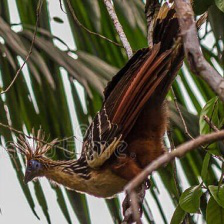

In [ ]:
img = (path/'train'/'HOATZIN').ls()[0]
PILImage.create(img)

##Construct DataBlock and DataLoaders

In [ ]:
birds = DataBlock(blocks=(ImageBlock,CategoryBlock),
                  get_items = partial(get_image_files,folders=['train','valid']),
                  splitter = RandomSplitter(seed=42),
                  get_y = parent_label,
                  item_tfms = Resize(150),
                  batch_tfms = aug_transforms(min_scale=0.75))

In [ ]:
dls = birds.dataloaders(path)

In [ ]:
# test_dl = dls.test_dl(get_image_files(path/'test'),with_labels=True)

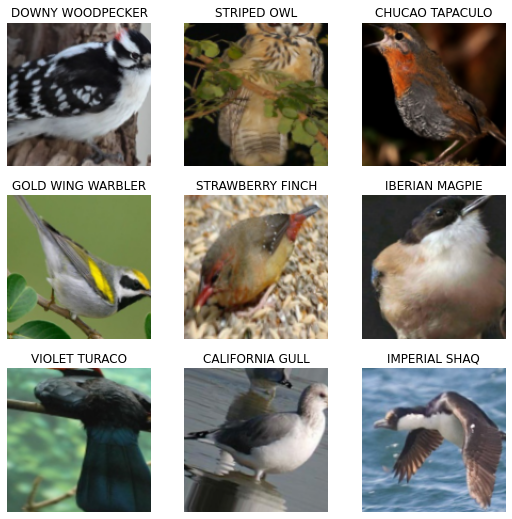

In [ ]:
dls.show_batch()

##Pre-trained Model
We will use Computer Vision pre-trained models from Ross Wightman's timm Library. Other great models and results are in his [repository](https://github.com/rwightman/pytorch-image-models)

In [ ]:
import timm
timm.list_models('beit*',pretrained=True)

['beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512']

In [ ]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [ ]:
body = create_timm_body('efficientnet_b3a', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [ ]:
nf = num_features_model(body); nf

1536

In [ ]:
head = create_head(nf, dls.c,concat_pool=True)

In [ ]:
net = nn.Sequential(body,head)

In [ ]:
learn = Learner(dls, net,splitter=default_split,metrics=accuracy)

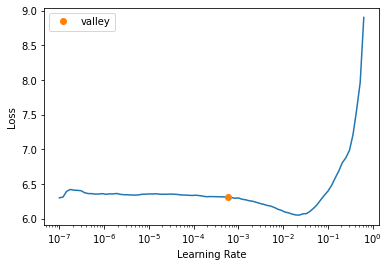

In [ ]:
first_lr = learn.lr_find()

In [ ]:
learn.fit_one_cycle(3,1e-3)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(5,freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,1.084001,0.847462,0.821562,02:55
1,0.898581,0.693981,0.833734,02:53
2,0.903684,0.705792,0.855924,02:53


epoch,train_loss,valid_loss,accuracy,time
0,0.567954,0.492787,0.888217,03:42
1,0.549042,0.448080,0.899975,03:42
2,0.439127,0.383572,0.913638,03:42
3,0.333215,0.323929,0.920344,03:42
4,0.295290,0.310834,0.922580,03:43


In [ ]:
learn.save('first_efficientnet_b3a')

Path('models/first_efficientnet_b3a.pth')

In [ ]:
learn = learn.load('first_efficientnet_b3a')

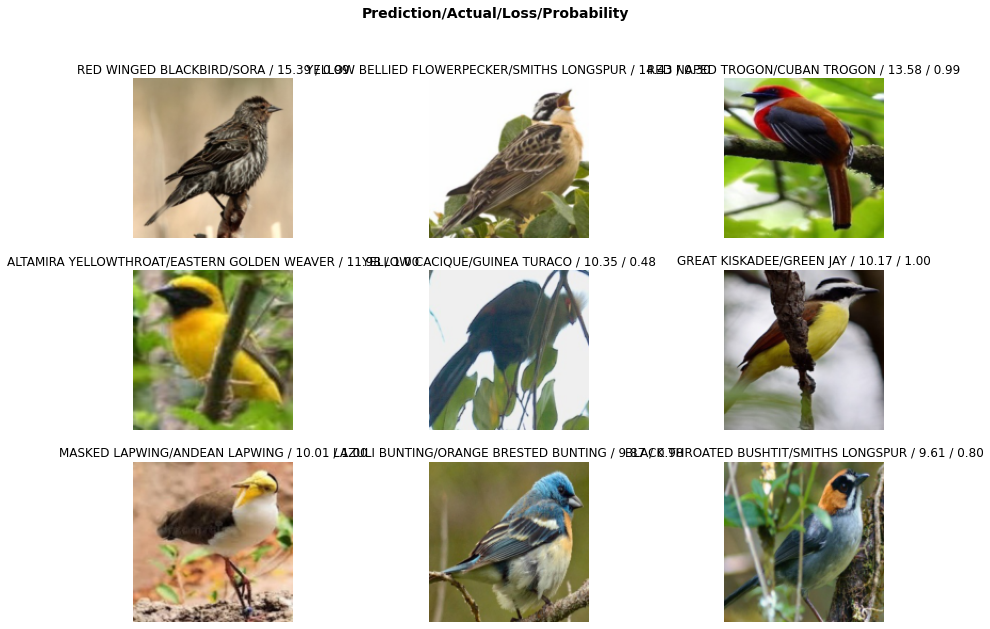

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
losses, idx, items= interp.top_losses(items=True)

In [ ]:
im = dls.valid_ds[idx[0]]

In [ ]:
inps,preds,targs,decoded = learn.get_preds(with_input=True,with_decoded=True)

In [ ]:
interp.most_confused(min_val=3)